In [1]:
from rubin_sim.scheduler.modelObservatory import Model_observatory
from rubin_sim.scheduler.surveys import BaseSurvey
from rubin_sim.scheduler.utils import empty_observation
from rubin_sim.scheduler.schedulers import Core_scheduler, simple_filter_sched
from rubin_sim.scheduler import sim_runner
from rubin_sim.scheduler.detailers import Base_detailer
from rubin_sim.utils import _approx_RaDec2AltAz,_approx_altaz2pa

import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd

Some things to note about the `rubin_sim.scheduler` package:

* Rubin observatory should make 800-1,000 observations in a night. That's too many to schedule manually. The goal of the scheduler package is to generate those observations
* Because there can be weather interuptions, the scheduler needs to be able to make fast real-time decisions.
* This means the scheduler is not solving an optimization problem. Rather, the goal of the scheduler is to be an artificial intelligence that can answer the question, "given the current progress and conditions, where is a good observation to make?"



In [2]:
# load up a model observatory.
nside=32  # Specify the HEALpix resolution we want to do everything in.
mo = Model_observatory(nside=nside)

In [3]:
conditions = mo.return_conditions()

In [4]:
conditions

In [5]:
# The conditions object has lots of attributes with information about the state of the telescope. 
print('mjd= %f, moonPhase=%f, night=%i' % (conditions.mjd, conditions.moonPhase, conditions.night))

mjd= 60218.000000, moonPhase=87.421653, night=0


In [6]:
conditions.mounted_filters

['u', 'g', 'r', 'i', 'y']

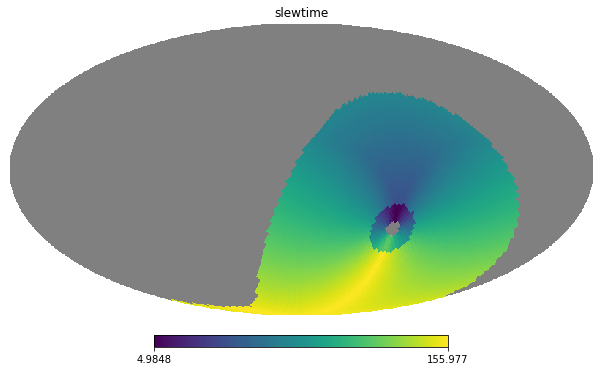

In [7]:
# some values in the conditions object are stored as HEALpix arrays
hp.mollview(conditions.slewtime, title='slewtime')

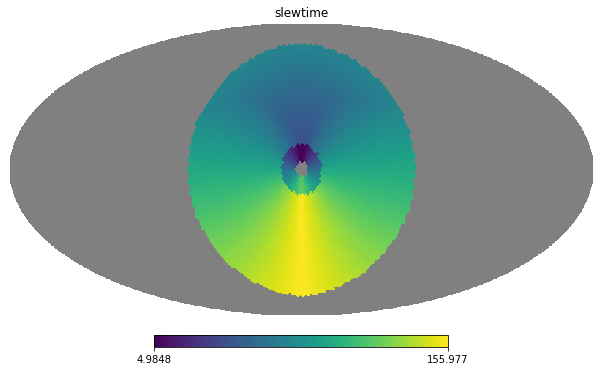

In [8]:
# All the HEALpix maps are stored as RA,dec. We can use the info in the conditions 
# object to rotate to alt,az (so zenith is at the center, north is up, hopefully east is left)
hp.mollview(conditions.slewtime, title='slewtime', rot=((conditions.lmst*180/12), conditions.site.latitude))

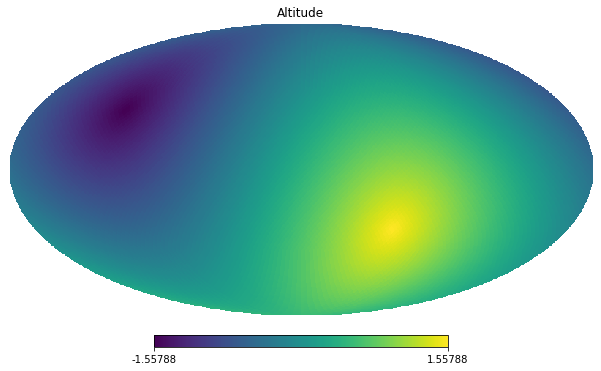

In [9]:
# Internal values are stored as radians, so here's the map of altitude, in radians
hp.mollview(conditions.alt, title='Altitude')

In [10]:
conditions.site.latitude_rad

-0.527864360290173

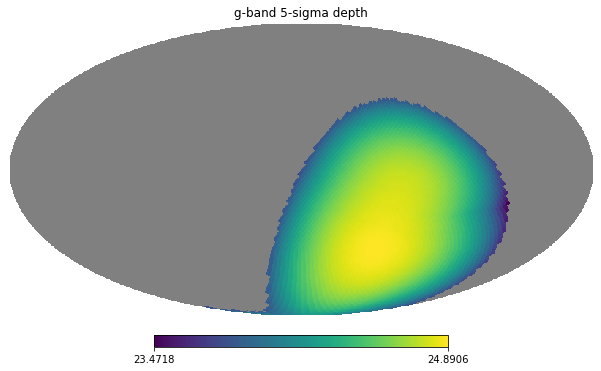

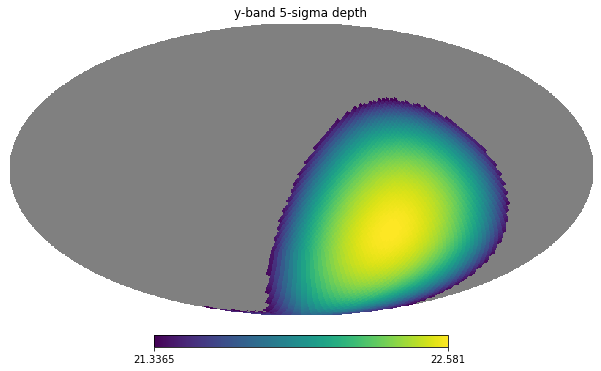

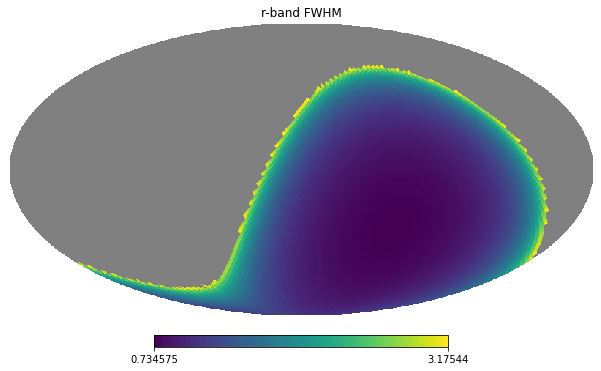

In [11]:
# If something is filter-specific, we usually store it in a dict with filtername keys
hp.mollview(conditions.M5Depth['g'], title='g-band 5-sigma depth')
hp.mollview(conditions.M5Depth['y'], title='y-band 5-sigma depth')
hp.mollview(conditions.FWHMeff['r'], title='r-band FWHM')


In [12]:
# All the things you can find in the condtions object should be in the doc string
help(conditions)

Help on Conditions in module rubin_sim.scheduler.features.conditions object:

class Conditions(builtins.object)
 |  Conditions(nside=None, site='LSST', exptime=30.0, mjd_start=59853.5, season_offset=None, sun_RA_start=None)
 |  
 |  Class to hold telemetry information
 |  
 |  If the incoming value is a healpix map, we use a setter to ensure the
 |  resolution matches.
 |  
 |  Unless otherwise noted, all values are assumed to be valid at the time
 |  given by self.mjd
 |  
 |  Methods defined here:
 |  
 |  __init__(self, nside=None, site='LSST', exptime=30.0, mjd_start=59853.5, season_offset=None, sun_RA_start=None)
 |      Parameters
 |      ----------
 |      nside : int
 |          The healpixel nside to set the resolution of attributes.
 |      site : str ('LSST')
 |          A site name used to create a sims.utils.Site object. For looking up
 |          observatory paramteres like latitude and longitude.
 |      expTime : float (30)
 |          The exposure time to assume when c

##Observation objects##

We have 2 types of observation objects--`observation` and `scheduled_observation`. As one might expect, an `observation` is something to be done immediatly, while a `scheduled_observation` is an observation to be done at a later time. 

A regular observation object is a numpy structured array that holds information about an observation. Survey objects are expected to return a list of these. Most of the values can be ignored (the observatory will fill them in with the actual values when the observation executes). Indeed, I'm not sure what would happen if you tried to fill in the moon phase. Hopefully it would just get overwritten with the correct value. 



In [13]:
# Generate an empty observation.
obs = empty_observation()

In [14]:
obs

array([(0, 0., 0., 0., 0., 0., '', 0., 0., 0, 0., 0., 0., 0., 0., 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., '', 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0)],
      dtype=[('ID', '<i8'), ('RA', '<f8'), ('dec', '<f8'), ('mjd', '<f8'), ('flush_by_mjd', '<f8'), ('exptime', '<f8'), ('filter', '<U1'), ('rotSkyPos', '<f8'), ('rotSkyPos_desired', '<f8'), ('nexp', '<i8'), ('airmass', '<f8'), ('FWHM_500', '<f8'), ('FWHMeff', '<f8'), ('FWHM_geometric', '<f8'), ('skybrightness', '<f8'), ('night', '<i8'), ('slewtime', '<f8'), ('visittime', '<f8'), ('slewdist', '<f8'), ('fivesigmadepth', '<f8'), ('alt', '<f8'), ('az', '<f8'), ('pa', '<f8'), ('clouds', '<f8'), ('moonAlt', '<f8'), ('sunAlt', '<f8'), ('note', '<U40'), ('field_id', '<i8'), ('survey_id', '<i8'), ('block_id', '<i8'), ('lmst', '<f8'), ('rotTelPos', '<f8'), ('rotTelPos_backup', '<f8'), ('moonAz', '<f8'), ('sunAz', '<f8'), ('sunRA', '<f8'), ('sunDec', '<f8'), ('moonRA', '<f8'), ('moonDec', '<f8'), ('moonDist', '<f8'), ('

In [15]:
# Again, here's a doc string that should have all the info on the fields and units.
help(empty_observation)

Help on function empty_observation in module rubin_sim.scheduler.utils.utils:

empty_observation()
    Return a numpy array that could be a handy observation record
    
    Returns
    -------
    numpy array
    
    The numpy fields have the following labels. These fields are required to be set to be a valid observation
    the model observatory can execute.
    RA : `float`
       The Right Acension of the observation (center of the field) (Radians)
    dec : `float`
       Declination of the observation (Radians)
    mjd : `float`
       Modified Julian Date at the start of the observation (time shutter opens)
    exptime : `float`
       Total exposure time of the visit (seconds)
    filter : `str`
        The filter used. Should be one of u, g, r, i, z, y.
    rotSkyPos : `float`
        The rotation angle of the camera relative to the sky E of N (Radians). Will probably be overridden if rotTelPos is not np.nan.
    rotTelPos : `float`
        The rotation angle of the camera re

**Survey Objects**

Survey objects generate potential targets. As you might guess, they take conditions objects as input. They also take completed observations as input. It's up to each survey object to log survey progress.

Let's make a survey object that generates a list of 3 observations near the south celestial pole every time it's called.

In [16]:
class SCP_survey(BaseSurvey):
    """A South Celestial Pole survey"""
    def generate_observations_rough(self, conditions):
        obs = empty_observation()
        obs['RA'] = 0.
        obs['dec'] = np.radians(-87.)
        obs['exptime'] = 30.
        obs['nexp'] = 2
        obs['filter'] = 'r'
        # If it's been 12 hours or more, don't try to execute the observation anymore
        obs['flush_by_mjd'] = conditions.mjd + 0.5
        obs['note'] = 'scp'  # Always good to set the note to which survey generated the observation
        #obs['rotTelPos'] = np.nan
        result = [obs] * 3
        return result
        

In [17]:
# By default, survey objects expect a list of basis functions on instatiation. But we 
# haven't talked about those yet, so we'll just send in an empty list
scp_survey = SCP_survey([])

In [18]:
observations = scp_survey.generate_observations(conditions)
# Pandas makes a prettier table to look at
pd.DataFrame(np.hstack(observations))

,ID,RA,dec,mjd,flush_by_mjd,exptime,filter,rotSkyPos,rotSkyPos_desired,nexp,...,sunAz,sunRA,sunDec,moonRA,moonDec,moonDist,solarElong,moonPhase,cummTelAz,scripted_id
0,0,0.0,-1.518436,0.0,60218.5,30.0,r,5.185965,0.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0.0,-1.518436,0.0,60218.5,30.0,r,5.185965,0.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0.0,-1.518436,0.0,60218.5,30.0,r,5.185965,0.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


We edited `generate_observations_rough`, but called `generate_observations`. That's because there are some nice defaults in the class so that it will automatically run a detailer to put in a reasonable value for `rotSkyPos` (It computes a value so `rotTelPos` will be zero). 

The other important method on a survey object is `calc_reward_function`. By default, it returns zero. But, when we start using multiple survey objects, the value of the reward function will be how the scheduler decides which survey object to call for observations.

In [19]:
scp_survey.calc_reward_function(conditions)

0

In [20]:
# Now to build our scheduler object, and let's run this for a day
scheduler = Core_scheduler([scp_survey], nside=nside)
mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=1.0,
                                                 verbose=True)

progress = 98.37%

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness_pre/SkyModelPre.py:410: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 979 observations
ran in 0 min = 0.0 hours
Writing results to  None


In [21]:
observations.size

979

In [22]:
# Now we can see most of that info has been filled in on our completed observations. 
observations[20]

(20, 0., -1.51843645, 60218.01011504, 60218.50925856, 30., 'r', 1.03272716, 0., 2, 1.89680262, 0.98008402, 1.73215657, 1.4758327, 20.75557432, 0, 2., 34., 0., 23.25485904, 0.55530557, 3.08954732, 5.25045815, 0., -0.04209366, -0.35098193, 'scp', 0, 0, 0, 20.15833616, 0., 0., 1.34997208, 4.43048686, 3.2576842, -0.05016166, 0.48375737, 0.20974933, 1.73413588, 1.57264271, 87.34529436, 3.08765189, 0)

Text(0, 0.5, 'Altitude (degrees)')

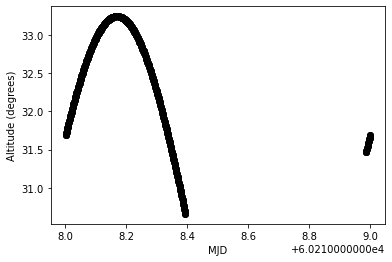

In [23]:
plt.plot(observations['mjd'], np.degrees(observations['alt']), 'ko')
plt.xlabel('MJD')
plt.ylabel('Altitude (degrees)')


Text(0, 0.5, 'sky brightness (mag/sq acrsec)')

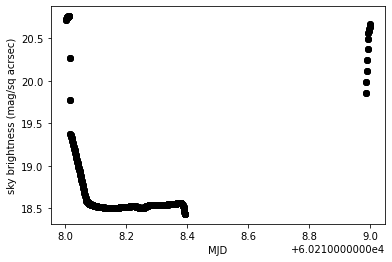

In [24]:
plt.plot(observations['mjd'], observations['skybrightness'], 'ko')
plt.xlabel('MJD')
plt.ylabel('sky brightness (mag/sq acrsec)')


Text(0, 0.5, 'Moon Altitude (degrees)')

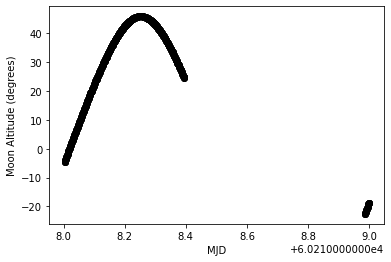

In [25]:
# Wait, magnitudes are backwards, why did the sky get brighter during the night?
plt.plot(observations['mjd'], np.degrees(observations['moonAlt']), 'ko')
plt.xlabel('MJD')
plt.ylabel('Moon Altitude (degrees)')


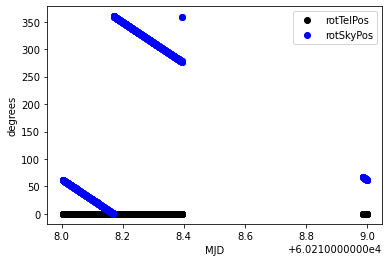

In [26]:
# How the camera rotator behaved. 
plt.plot(observations['mjd'], np.degrees(observations['rotTelPos']), 'ko', label='rotTelPos')
plt.plot(observations['mjd'], np.degrees(observations['rotSkyPos']), 'bo', label='rotSkyPos')
plt.ylabel('degrees')
plt.xlabel('MJD')
plt.legend()

OK, rotTelPos is exactly zero, so it was using that value.

Note, if you have `sim_runner` output the results to a sqlite file, it does some schema name converting, and does  radians to degrees conversions. That whole schema is in the docs here: https://rubin-sim.lsst.io/rs_scheduler/output_schema.html

In [27]:
# OK, let's reset and run a scripted survey and our SCP survey at the same time!
# Maybe then an example of filter picking logic inside the survey object, then with 2 survey objects.
# Then move on to wide area survey. 

In [28]:
# Add an example of holding rotSkyPos constant, and seeing the rotTelPos spin.
# or maybe add a detailer so the rotSkyPos is 0, 90, or 270

In [29]:
# OK, so a detailer is an object that takes a list of observations and the current conditions, 
# and returns a list of observations. So you might do something like, "repeat the list until expected sunrise",
# or, "repeat in 3 different filters". 
# Let's make a detailer to adjust the rotation angle

class PerpRot_detailer(Base_detailer):
    def __call__(self, observation_list, conditions):
        possible_rot_sky = np.array(np.radians([0.,90.,270.]))
        # Note, this is a stupid loop. It's fine to 
        # concatenate the obs_list into an array, do array operations,
        # then convert it back to a list at the end.
        for obs in observation_list:
            # Set rotTelPos to NaN, forcing observatory to use rotSkyPos
            obs['rotTelPos'] = np.nan
            alt, az = _approx_RaDec2AltAz(obs["RA"],obs["dec"],
                                          conditions.site.latitude_rad,
                                          conditions.site.longitude_rad,
                                          conditions.mjd)
            obs_pa = _approx_altaz2pa(alt, az, conditions.site.latitude_rad)
            possible_rtp = possible_rot_sky + obs_pa
            possible_rtp = possible_rtp % (2.*np.pi)
            in_range = np.min(np.where((possible_rtp > 3.*np.pi/2) | (possible_rtp < np.pi/2))[0])
            obs['rotSkyPos'] = possible_rot_sky[in_range]
        return observation_list

In [30]:
# reset our model observatory
mo = Model_observatory(nside=nside)


In [31]:
# Make our survey object, this time with our detailer
scp_survey = SCP_survey([], detailers=[PerpRot_detailer()])

scheduler = Core_scheduler([scp_survey], nside=nside)
mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=1.0,
                                                 verbose=True)

progress = 98.37%

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness_pre/SkyModelPre.py:410: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 979 observations
ran in 1 min = 0.0 hours
Writing results to  None


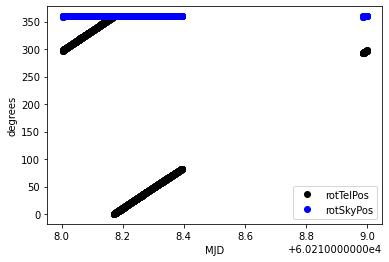

In [32]:
# How the camera rotator behaved. 
plt.plot(observations['mjd'], np.degrees(observations['rotTelPos']), 'ko', label='rotTelPos')
plt.plot(observations['mjd'], np.degrees(observations['rotSkyPos']), 'bo', label='rotSkyPos')
plt.ylabel('degrees')
plt.xlabel('MJD')
plt.legend()

In [33]:
# So this slight offset is probably the way the observatory model is dealing with things.
np.degrees(observations['rotSkyPos'])[0:10]

array([359.05164626, 359.05164626, 359.05164626, 359.69496674,
       359.69496674, 359.69496674, 359.69489475, 359.69489475,
       359.69489475, 359.69482295])

In [34]:
# One can daisy-chain as many detailers as you like in a row. Note they are applied in order, and 
# do not always commute.